In [70]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *
#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit

print(cf.base_directory)
from cmath import nan
import h5py    


user_settings = getattr(cf.plot_settings, 'settings')


../results/HEISENBERG/disorder/PBC/


# XYZ TESTS

../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=8,J=0.50,J0=0.50,g=0.90,g0=0.90,h=0.80,w=0.20_subsize=4.hdf5
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=10,J=0.50,J0=0.50,g=0.90,g0=0.90,h=0.80,w=0.20_subsize=5.hdf5
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=12,J=0.50,J0=0.50,g=0.90,g0=0.90,h=0.80,w=0.20_subsize=6.hdf5
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=14,J=0.50,J0=0.50,g=0.90,g0=0.90,h=0.80,w=0.20_subsize=7.hdf5
../results/XYZ/disorder/OBC/Entropy/Eigenstate/_L=16,J=0.50,J0=0.50,g=0.90,g0=0.90,h=0.80,w=0.20_subsize=8.hdf5


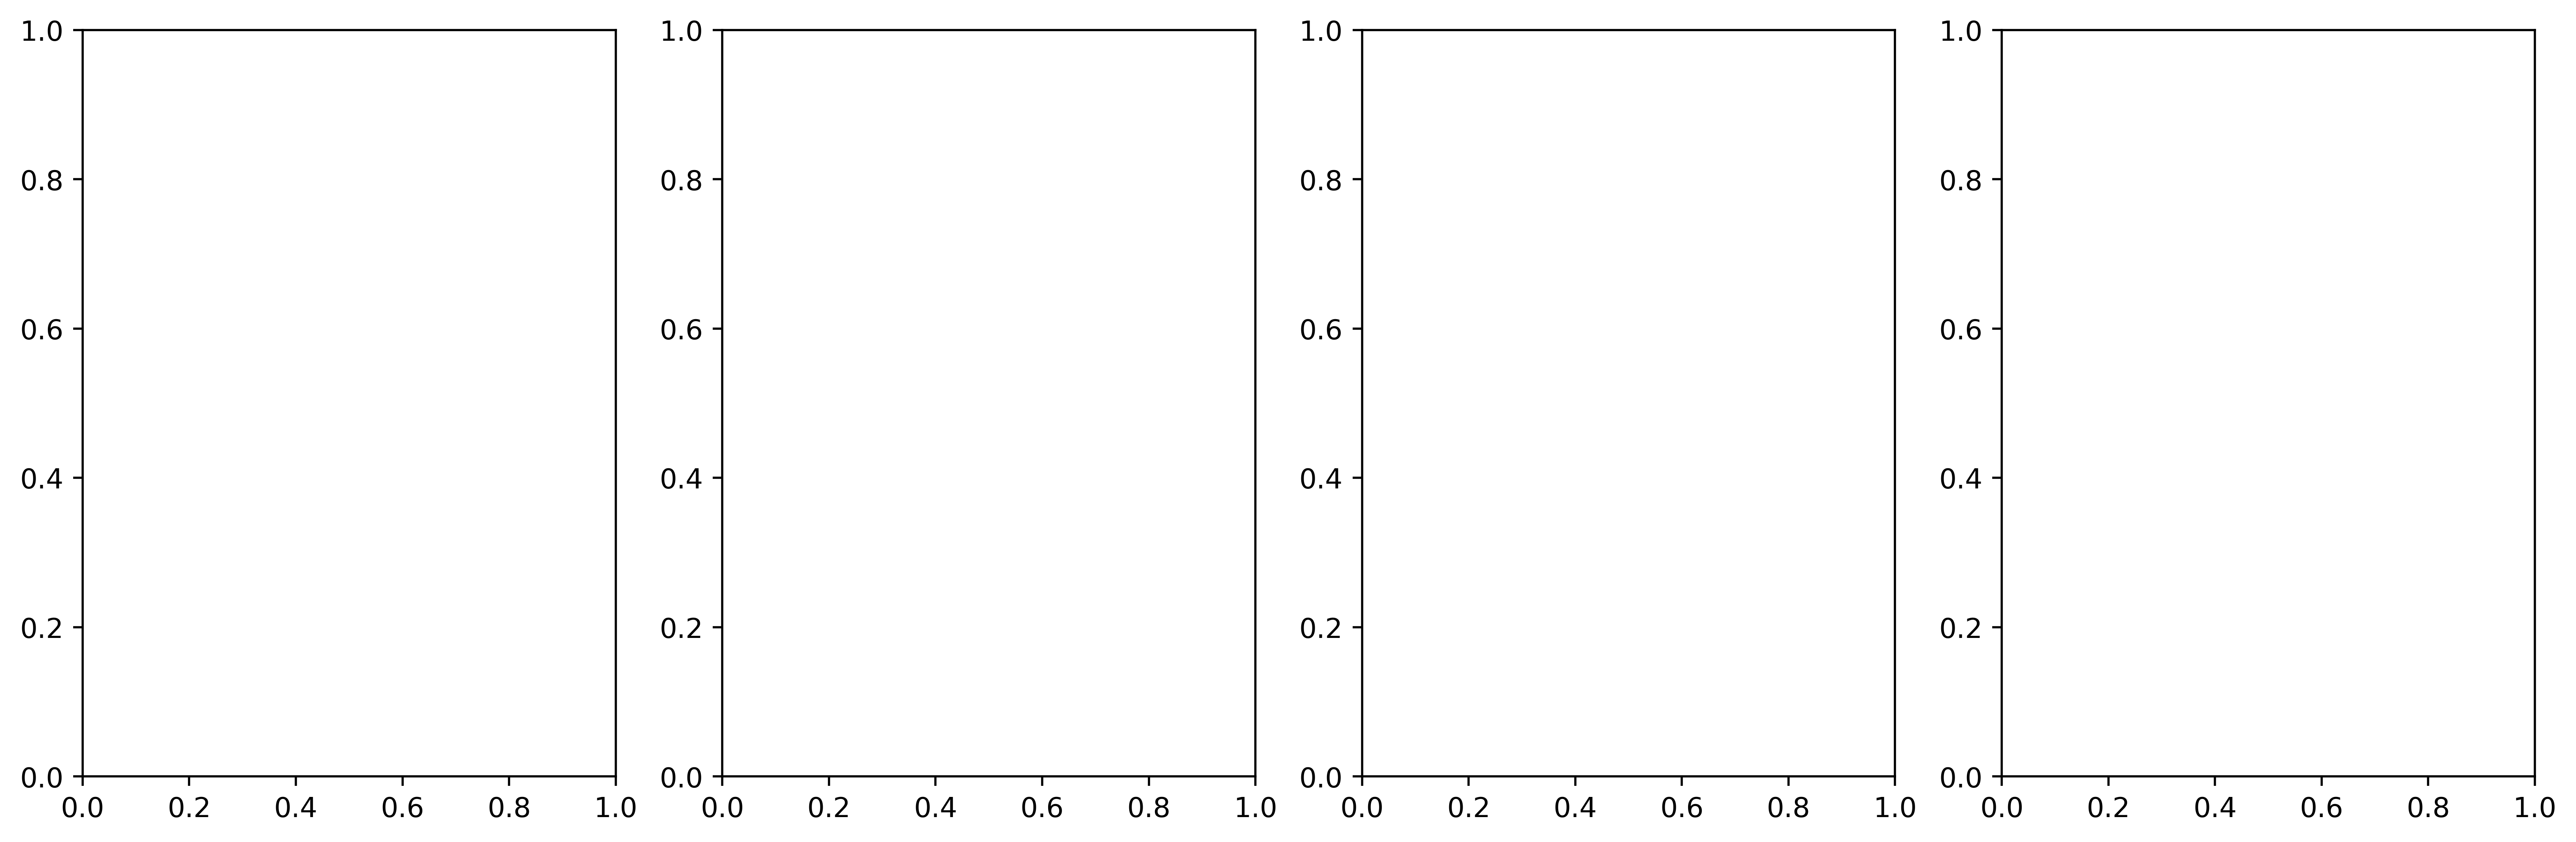

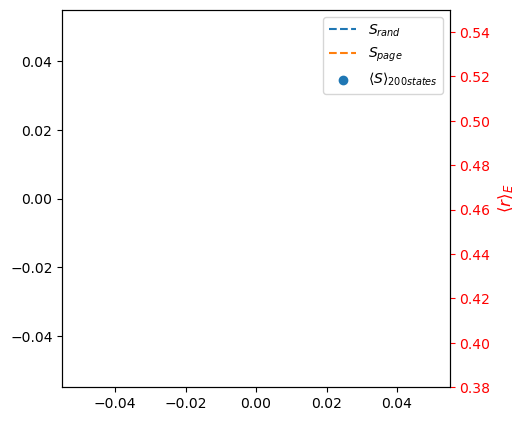

In [67]:
from statistics import mean

SYMMETRIES = 0
dir = "../results/XYZ/symmetries/PBC/Entropy/Eigenstate/" if SYMMETRIES else "../results/XYZ/disorder/OBC/Entropy/Eigenstate/"
L=10
J=0.5
J0=0.5
g=0.9
g0=0.9
h=0.8
w=0.2
k=0
p=1
x=1

fig, ax = plt.subplots( nrows=1, ncols=4, figsize=(16,5), dpi = 500)

validL = []
Smean = []
gap_ratio = []
def plot_here(axis, L):
    info = hfun.info_sym(L, J, g, h, k, p, x) if SYMMETRIES else hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    
    Smax = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
    Spage = L * np.log(2) / 2. - 0.5
    filename = info + "_subsize=%d.hdf5"%(L/2)
    print(filename)
    if exists(filename):
        data = []
        with h5py.File(filename, "r") as f:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print("Keys: %s" % f.keys())
            energies = np.array(f.get('energies')[0])
            entropy = np.array(f.get('entropy')[0])
            print(entropy)
            #eigenvectors = np.array(f.get('eigenvectors'))
        
        axis.scatter(energies, entropy, label=r"$L=%d$"%L, s=4)
        axis.axhline(y=Smax, linestyle='--', color='black', label="Vidmar2019")
        axis.axhline(y=Spage, linestyle='--', color='red', label="Page")
        axis.set_ylim(0, 5.5)
        axis.set_xlim(-10, 15)
        axis.legend()
        # ENTROPY USING NUMPY
        #entropy_python = []
        #nA = int(2**(L/2))
        #for state in eigenvectors:
        #    rho = np.outer(state, state).reshape([nA, nA, nA, nA])
        #    rho_a = np.trace(rho, axis1=1, axis2=3)
        #    rho_b = np.trace(rho, axis1=0, axis2=2)
        #    U, s, V = np.linalg.svd(rho_a)
        #    entropy_python.append(-np.sum(s * np.log(s)))
        #    #entropy_python.append(-np.trace(rho_a * np.log(rho_a)))
        #entropy_python = np.array(entropy_python)
        #axis.scatter(energies, entropy_python, marker='s', facecolor='None', edgecolor='red', label=r"$L=%d$"%L,s=10)
        #diff = np.abs(entropy - entropy_python)
        #diff = [x for x in diff if x > 1e-14]
        #print(diff)
        
        # get mean
        size = energies.size
        my_min = int(0.5 * size - 250)
        my_max = int(0.5 * size + 250)
        print(size, my_min, my_max)
        
        sample = entropy[my_min : my_max]
        
        meanS = np.mean(sample)
        validL.append(L)
        Smean.append(meanS)
        gaps = np.diff(energies)
        
        ratio = 0
        counter = 0
        for i in range(int(0.25 * size), int(0.75 * size)):
            ratio += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
            counter += 1
        gap_ratio.append(ratio / counter)


plot_here(axis=ax[0], L=8)
plot_here(axis=ax[0], L=10)
plot_here(axis=ax[1], L=12)
plot_here(axis=ax[2], L=14)
plot_here(axis=ax[3], L=16)
#plot_here(axis=ax[2], L=18)

def page(L):    
    return L * np.log(2) / 2. - 0.5
def Srand(L): 
    return L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
#Ls = np.array(range(7,17))
validL = np.array(validL)
#ax[3].scatter(validL, np.abs(np.array(Smean) - page(validL)), label=r"$\langle S\rangle_{200\ states}-S_{page}$")
#ax[3].plot(Ls, np.abs(Srand(Ls) - page(Ls)), linestyle='--', label=r"$S_{rand}-S_{page}$")
#ax[3].legend()
#ax[3].set_xlim(6, 18)
#ax[3].set_xscale('log')
#ax[3].set_yscale('log')

#plt.savefig("../swap results/Heisenberg/DISORDER/PLOTS_FOR_PAPER1/Fig1.pdf")
#plt.savefig("../swap results/Heisenberg/DISORDER/PLOTS_FOR_PAPER1/Fig1.png")

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
ax_1 = ax.twinx()
ax.scatter(validL, Smean, label=r"$\langle S\rangle_{200 states}$")
ax.plot(validL, Srand(validL), linestyle='--', label=r"$S_{rand}$")
ax.plot(validL, page(validL), linestyle='--', label=r"$S_{page}$")
ax_1.scatter(validL, gap_ratio, color='red')
ax_1.set_ylim(0.38, 0.55)
ax_1.set_ylabel(r"$\langle r\rangle_E$", color='red', fontsize=12)
ax_1.tick_params(axis='y', color='red', labelcolor='red')
ax.legend()

[]


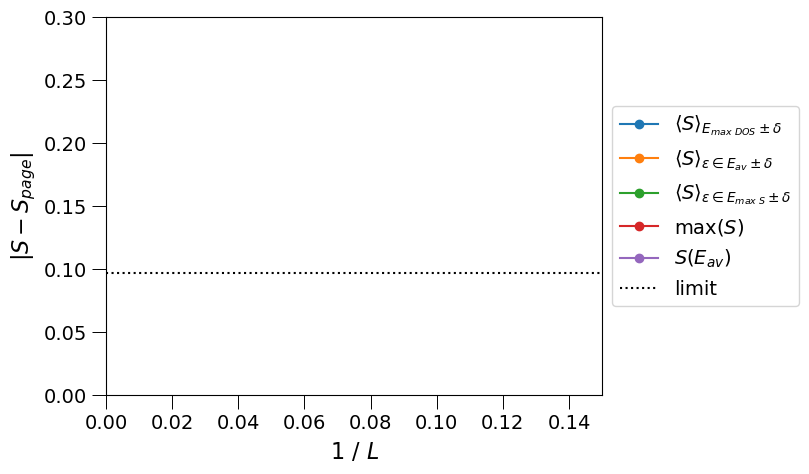

In [62]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 100)

Smean_ener = []
S_dos = []
S_max_ent = []
validL = []
Smax = []
S_at_Eav = []

for L in range(8, 17, 2):    
    info = hfun.info_sym(L, J, g, h, k, p, x) if SYMMETRIES else hfun.info_dis(L, J, J0, g, g0, h, w)
    info = dir + info[0 : info.index('.dat') :]
    
    filename = info + "_subsize=%d.hdf5"%(L/2)
    if exists(filename):
        data = []
        with h5py.File(filename, "r") as f:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            print("Keys: %s" % f.keys())
            energies = np.array(f.get('energies')[0])
            entropy = np.array(f.get('entropy')[0])
        
        
        size = energies.size

        # get mean energy
        def get_S(idx):
            num = 500 if L > 8 else 100
            #num = 0.5 * size
            my_min = int(idx - num / 2);    
            if my_min < 0: my_min = 0
            my_max = int(idx + num / 2);    
            if my_max>= size: my_max = size

            print(size, my_min, my_max, idx)
            sample = entropy[my_min : my_max]
            return np.mean(sample)

        E_av = np.sum(energies) / size
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        Smean_ener.append(get_S(idx))
        S_at_Eav.append(entropy[idx])

        E_av = np.median(energies)
        idx = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
        S_dos.append(get_S(idx))
        
        E_av = max(entropy)
        idx = min(range(len(entropy)), key=lambda i: abs(entropy[i] - E_av))
        S_max_ent.append(get_S(idx))

        Smax.append(max(entropy))
        
        validL.append(L)

def Srand(L): 
    return L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5

def page(L):    
    return L * np.log(2) / 2. - 0.5
validL = np.array(validL)
def plot_with_fit(axis, sizes, entropy, label = "oh"):
    ydata = np.abs(entropy - page(sizes))

    p = axis.plot(1. / sizes, ydata, marker='o', label=label)
    #pars, sth = fit(f=lin_fit_inv, 
    #                    xdata=sizes[2:], 
    #                    ydata=ydata[2:])
    #
    #Ls = np.linspace(0, 0.2, 100)
    #axis.plot(Ls, lin_fit_inv(1./Ls, *pars), linestyle='--', color=p[0].get_color())

plot_with_fit(axis=ax, sizes=validL, entropy=S_dos, label=r"$\langle S \rangle_{E_{max\ DOS}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=Smean_ener, label=r"$\langle S\rangle_{\epsilon\in E_{av}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=S_max_ent, label=r"$\langle S\rangle_{\epsilon\in E_{max\ S}\pm\delta}$")
plot_with_fit(axis=ax, sizes=validL, entropy=Smax, label=r"$\max(S)$")
plot_with_fit(axis=ax, sizes=validL, entropy=S_at_Eav, label=r"$S(E_{av})$")
print(Smax)
ax.axhline(y=0.0966, linestyle=':', color='black', label="limit")
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,0.15)
ax.set_ylim(0,0.3)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

hfun.set_plot_elements(axis = ax, ylabel = "|S-S_{page}|", xlabel = "1\ / \ L", settings=user_settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))

ax.legend(frameon=True, ncol=1
                , loc='center left', bbox_to_anchor=(1, 0.5)
                , fontsize=14)
ax.set_xscale('linear');    ax.set_yscale('linear')

# HEISENBERG RESULTS

_L=*,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=*_subsize=*_jobid=*.hdf5
[10, 12, 14, 16, 18]
[0.02  0.025 0.027 0.029 0.031 0.033 0.035 0.038 0.04  0.041 0.043 0.044
 0.046 0.047 0.049 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.063 0.065
 0.066 0.068 0.069 0.071 0.072 0.074 0.076 0.078 0.079 0.08  0.081 0.083
 0.085 0.087 0.089 0.091 0.093 0.096 0.098 0.1   0.11  0.12  0.13  0.14
 0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26
 0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38
 0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  0.5
 0.51  0.52  0.54  0.55  0.56  0.58  0.59  0.6   0.62  0.63  0.64  0.65
 0.66  0.68  0.69  0.7   0.71  0.72  0.74  0.76  0.78  0.8   0.81  0.82
 0.83  0.84  0.86  0.87  0.88  0.89  0.9   0.92  0.93  0.94  0.95  0.96
 0.98  1.    1.02  1.07  1.1   1.15  1.17  1.23  1.32  1.41  1.51  1.62
 1.74  1.86 ]
[   0    1    2    3    4  100  200  300  400  500  600  700  800  900
 1000 1100 1200 1300 1400 1500 

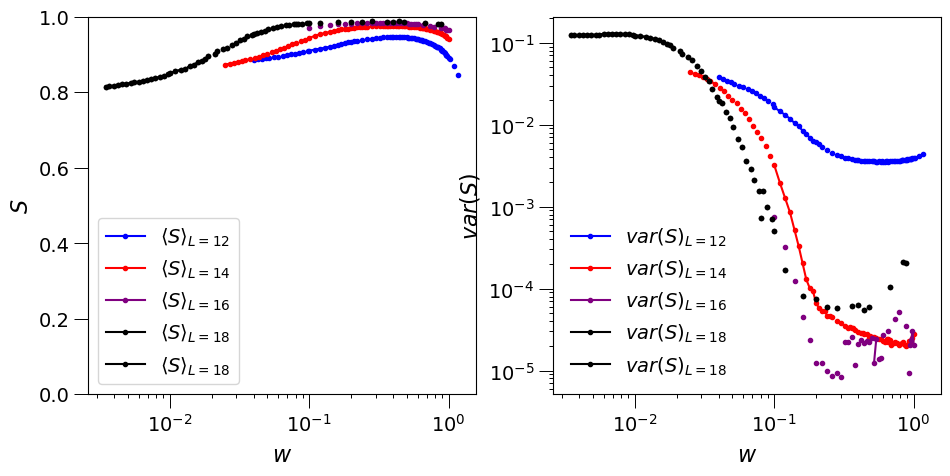

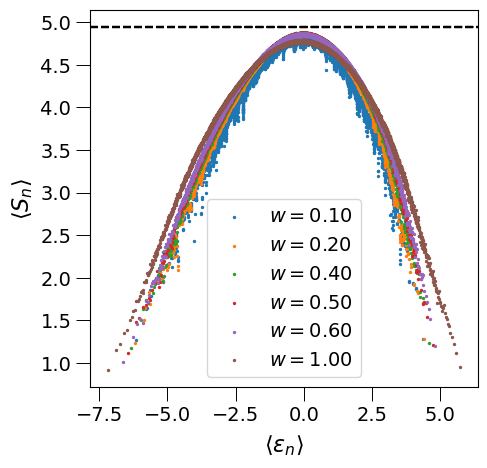

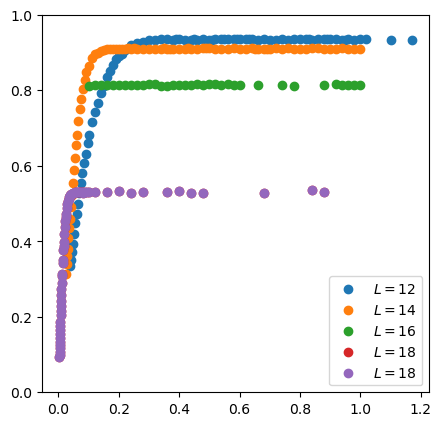

In [88]:
reload_modules()

from fnmatch import fnmatch as fn
dir_in = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}raw_data{os.sep}"
dir_out = f"{cf.base_directory}Entropy{os.sep}Eigenstate{os.sep}"


set_class = copy.deepcopy(cf.plot_settings)
set_class.set_scaling('w')
set_class.set_vs('x')
settings = getattr(set_class, 'settings')

SINGLE_REALISATION = 0

ii = settings['scaling_idx']
info = ""
# ASSUMING DISORDER MODULE FOR NOW
arr = [cf.J, cf.J0, cf.g, cf.g0, cf.h, cf.w]
names = ['J', 'J0', 'g', 'g0', 'h', 'w']
indices = [-1, 0, 2, 4, 5]
def create_info(use_log_data = True):
    info = "_L=*"
    for i, var in enumerate(arr):
        n = hfun.order_of_magnitude(var) if use_log_data else 2
        if i == indices[ii]:
            info += ",%s=*"%names[i]
        else: info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info + "_subsize=*_jobid=*.hdf5"
info = create_info()
print(info)

sizes = []
collected_pars = []
realis = []
#--------------------------------------- COLLECT DATA
def append_parameter_range(filename):
    if fn(filename, info):
        bare_info, extension = os.path.splitext(filename)
        
        f = os.path.join(dir_in, filename)
        if os.path.isfile(f):
            pars = hfun.get_params_from_info(bare_info)
            
            if pars[ii] not in collected_pars:  collected_pars.append(pars[ii])
            if pars[0] not in sizes:            sizes.append(int(pars[0]))
            if pars[-1] not in realis:          realis.append(int(pars[-1]))

for filename in os.listdir(dir_in): 
    info = create_info()
    append_parameter_range(filename)
    info = create_info(False)
    append_parameter_range(filename)

pars = cf.params_arr
sizes = list(np.sort(sizes))
collected_pars = np.sort(collected_pars)
realis = np.sort(realis)
print(sizes)
print(collected_pars)
print(realis)
lab = hfun.var_name if settings['scaling_idx'] == 2 else settings['scaling']
vals = hfun.get_scaling_array(settings, x0=0.1, xend=1.0, dx=0.1)

sizes = sizes if ii != 0 else [0];
entropy = []
colors = {
    10: 'green',
    12: 'blue', 
    14: 'red',
    16: 'purple', 
    18: 'black'
    }
fig, (ax, axis) = plt.subplots( nrows=1, ncols=2, figsize=(11,5), dpi = 100)
fig, ax2 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
fig, ax3 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)


param_copy = copy.deepcopy(cf.params_arr)
sizes.append(18);   sizes = np.array(sizes)

for L in sizes[1:]:
    new_pars = pars
    if ii != 0:
        new_pars[0] = L

    info_out = dir_out + hfun.remove_info(hfun.info_param(new_pars), settings['scaling']) + "_subsize=%d.hdf5"%(L/2)
    S = []
    i = 0
    Smax = []
    Svar = []

    x = []
    gaps = []
    if L == 18:
        cf.params_arr[settings['scaling_idx']] = L
        filename = cf.base_directory + "STATISTICS" + os.sep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['scaling']) + ".dat" 
        if os.path.exists(filename):
            stats = hfun.read_python_saved_dat_file(filename)
            
            x = stats[0]
            gaps = stats[1]
            S = stats[4]
            Smax = [np.nan for i in range(x.size)]
            Svar = stats[7]
    else:
        x = collected_pars

        for par in collected_pars:
            new_pars[ii] = par
            info_in = hfun.info_param(new_pars)
            base_info, ext = os.path.splitext(info_in)

            info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%realis[0]
            if SINGLE_REALISATION:
                info_in = "realisation=%d"%0 + os.sep + base_info + "_subsize=%d"%(L/2) + ".hdf5"
            ener = [0 for i in range(int(binom(L, int(L/2))))]
            ent = [0 for i in range( int(binom(L, int(L/2))))]
            counter = 0.0
            Sall = []
            rall = 0
            for r in (realis  if SINGLE_REALISATION == 0 else [0]):
                info_in = base_info + "_subsize=%d"%(L/2) + "_jobid=%d.hdf5"%r
                if os.path.exists(dir_in + info_in):
                    with h5py.File(dir_in + info_in, "r") as f:
                        # Print all root level object names (aka keys) 
                        # these can be group or dataset names
                        E = np.array(f.get('energies')[0])
                        ener += E
                        ent += np.array(f.get('entropy')[0])
                        counter += 1.0
                        r=0;
                        cunt = 0
                        for i in range(E.size):
                            if i > int(0.25 * E.size) and i < int(0.75 * E.size):
                                gap1 = E[i] - E[i - 1];
                                gap2 = E[i + 1] - E[i];
                                if gap1 <= 1e-15:
                                    print("Degeneracy", E[i-5 : i+5])
                                r += min(gap1, gap2) / max(gap1, gap2)
                                cunt += 1.0
                        r /= cunt
                        rall += r
            if counter > 0:
                gaps.append(rall / counter)
            else:
                gaps.append(np.nan)

            ener = np.array(ener) / counter
            ent = np.array(ent) / counter



            if par in vals and L == 16 and max(ent) > 1e-2:
                norm = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
                ax2.axhline(y=norm, linestyle='--', color='black')
                ax2.scatter(ener, ent, label=r"$%s=%.2f$"%(lab, par), s=2)

            idx_min = int(0.5 * ent.size) - 250
            idx_max = int(0.5 * ent.size) + 250  
            ent = ent[idx_min : idx_max]
            S.append(np.mean(ent))
            Smax.append(max(ent))
            Svar.append(np.var(ent))

    Smax = np.array(Smax)        
    norm = L * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5 
    ax.plot(x, S / norm, label=r"$\langle S\rangle_{L=%d}$"%L, marker = 'o', markersize=3, color=colors[L])
    #ax.scatter(x, Smax / norm, marker='s', edgecolor=colors[L], facecolor='None', label=r"$S^{max}_{L=%d}$"%L,s=8)  
    ax3.scatter(x, gaps, label=r"$L=%d$"%L)
    ax3.set_ylim(0., 1.)
    axis.plot(x, Svar, marker = 'o', markersize=3, color=colors[L], label=r"$var(S)_{L=%d}$"%L)    

    entropy.append(np.array(S))  

cf.params_arr = param_copy
hfun.set_plot_elements(axis = ax, ylabel = "S", xlabel = lab, settings=settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))
hfun.set_plot_elements(axis = axis, ylabel = "var(S)", xlabel = lab, settings=settings, 
                            font_size=14, set_legend=True, xlim=(None, None), ylim=(None, None))

ax.legend(frameon=True, ncol=1
                , loc='best'
                , fontsize=14)
ax.set_xscale('log');    ax.set_yscale('linear')
ax.set_ylim(0,1)
hfun.set_plot_elements(axis = ax2, xlabel = "\\langle \\epsilon_n\\rangle", ylabel = "\\langle S_n\\rangle", settings=settings, 
                            font_size=14, set_legend=False, xlim=(None, None), ylim=(None, None))
ax2.legend(frameon=True, ncol=1
                , loc='best'
                , fontsize=14)
ax2.set_xscale('linear');    ax2.set_yscale('linear')
fig.subplots_adjust(wspace=0.4, hspace=0.2)

ax3.legend()
